In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import category_encoders as ce

import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
# kaggle competitions download -c playground-series-s4e9
train_data = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv")

In [3]:
def iden_missing_val(df, del_criteria = 0.8):
    
    float_col = list(df.select_dtypes(include=['int64', 'float','float32','float64']).columns)
    object_col = list(df.select_dtypes(include=['object']).columns)

    col_del_1 = [i for i in df.columns if df[i].isnull().sum()/len(df)>=del_criteria]
    col_complete = [i for i in df.columns if i not in col_del_1]
    
#     print(f"Variables with missing value more than {del_criteria*100}% is \n {col_del_1}" )

    num_col = [i for i in float_col if i in col_complete]
    cat_col = [i for i in object_col if i in col_complete]

    return num_col, cat_col

num_col, cat_col = iden_missing_val(train_data)
num_col.pop(num_col.index('id'))
num_col.pop(num_col.index('price'))

'price'

In [4]:
train_data[num_col] = train_data[num_col].fillna(train_data[num_col].median())

In [5]:
def num_pdf(df):

    num_col = list(df.select_dtypes(include=['int64', 'float','float32','float64']).columns)
    nrows = int(np.sqrt(len(df[num_col].columns)))
    nelements = len(num_col)
    ncols = int(nelements/nrows)+1

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, tight_layout=True, figsize=(20, nrows*20/ncols), dpi=100)
    axs = axs.flatten()

    for ind, i in enumerate(num_col):
        sns.histplot(df[i], kde=True, ax=axs[ind], element='step', stat='density')

    for i in range(nrows*ncols-nelements):
        fig.delaxes(axs[nelements-i])

    plt.show()

# num_pdf(train_data[num_col])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


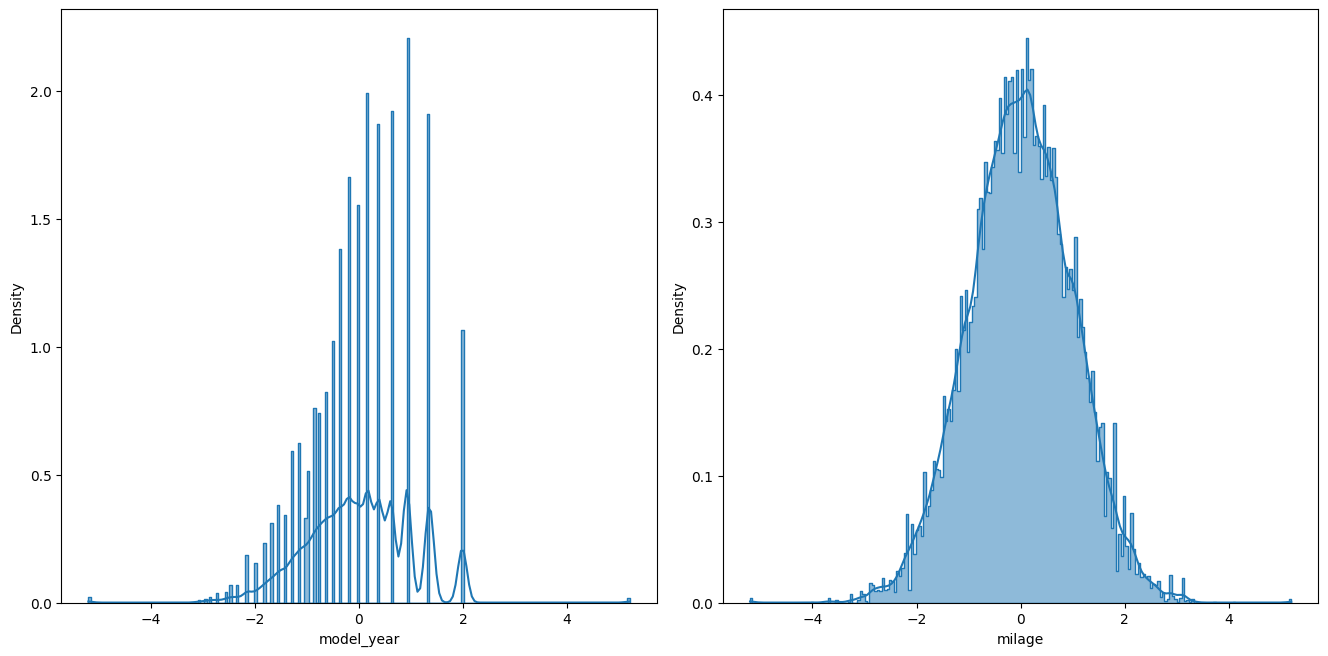

In [6]:
def normalize(df):
  qt = QuantileTransformer(output_distribution='normal', random_state=42)
  return qt.fit_transform(df)

train_data[num_col] = normalize(train_data[num_col])
num_pdf(train_data[num_col])

In [7]:
X = train_data[num_col + cat_col]
y = train_data['price']
encoder = ce.CatBoostEncoder()
encoder.fit(X, y)
X_enc = encoder.transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

params = {
        'objective': 'reg:squarederror',
        'n_estimators': 300, 
        "verbosity": 0,
        "tree_method": "exact"
        }

# Create the DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the model
model = xgb.train(params, dtrain)

# Predict probabilities for the test set
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)


In [9]:
from sklearn.metrics import mean_squared_error 
import math 

mean_squared_error(y_test, y_pred)**(1/2)

67313.9642843574

In [10]:
num_col, cat_col = iden_missing_val(test_data)
num_col.pop(num_col.index('id'))
test_data[num_col] = test_data[num_col].fillna(test_data[num_col].median())
test_data[num_col] = normalize(test_data[num_col])
submission_test = encoder.transform(test_data[num_col + cat_col])

submission_test = xgb.DMatrix(submission_test)
submission = model.predict(submission_test)


In [11]:
final = pd.DataFrame(columns = ['id', 'class'])
final['id'] = test_data['id']
final['class'] = pd.DataFrame(submission, columns =['price'])
final.to_csv('submission.csv', index = False)